## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSSB'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
df = df[df.elevation >-999]
print(df.count())
#df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1180


In [28]:
#extract longitude and latitude for each station
feature='coeff_2'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_2 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_2|
+-----------+--------+---------+---------+-------------------+
|USC00045915| 37.8792|-121.9303|    661.4|-189.46011826610393|
|USC00049423| 37.8833|-122.0333|     74.7| -6.243226371695742|
|USC00040227| 38.0167|-121.7667|      8.5| -95.95010735824565|
|USC00045032| 38.1061|-121.2878|     12.2| -338.0015719715238|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [29]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head()

,station,latitude,longitude,elevation,count(station),avg(coeff_2)
22,USC00040227,38.0167,-121.7667,8.5,30,-140.733611
32,USC00040232,37.9856,-121.7458,18.3,44,-223.840108
24,USC00040693,37.8744,-122.2606,94.5,41,297.125444
0,USC00041043,38.1167,-121.7000,9.1,9,-285.284258
14,USC00041206,37.5833,-122.3500,3.0,25,312.126409


In [30]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(200)

u'#ffdb00'

## Map

In [31]:
print df.columns
df.describe(['elevation', 'latitude', 'longitude', 'year']).show()

['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'label', 'latitude', 'longitude', 'measurement', 'res_1', 'res_2', 'res_3', 'res_mean', 'station', 'total_var', 'undefs', 'vector', 'year']
+-------+------------------+-------------------+-------------------+------------------+
|summary|         elevation|           latitude|          longitude|              year|
+-------+------------------+-------------------+-------------------+------------------+
|  count|              1180|               1180|               1180|              1180|
|   mean| 72.22364406779663| 37.854286271186446|-121.93841957627119|1972.0728813559322|
| stddev|143.48118964327978|0.16970346671100978| 0.4593604158893034|22.213012489003667|
|    min|               2.4|            37.5147|          -122.5447|            1901.0|
|    max|             661.4|               38.2|          -120.8667|            2012.0|
+-------+------------------+-------------------+-------------------+------------------+



In [32]:
min_lat,max_lat,min_long,max_long = box = (37.48, 38.22, -123.2, -120.8)


In [33]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1000*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

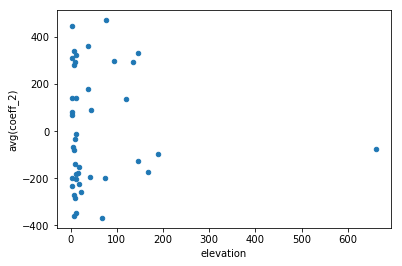

In [34]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_2)');